In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

## 二分法(bi-partition)处理连续性属性  
**注意：**与离散属性不同，若当前划分属性为连续属性，则后续划分时还可以使用该属性

In [2]:
density = [
    0.697, 0.774, 0.634, 0.608, 0.556, 0.403, 0.481,
    0.437, 0.666, 0.243, 0.245, 0.343, 0.639, 0.657,
    0.360, 0.593, 0.719
]
density.sort()

In [3]:
for i in range(len(density)-1):
    divide_point = (density[i] + density[i+1])/2
    print(divide_point)

0.244
0.29400000000000004
0.35150000000000003
0.3815
0.42000000000000004
0.45899999999999996
0.5185
0.5745
0.6005
0.621
0.6365000000000001
0.648
0.6615
0.6815
0.708
0.7464999999999999


## 西瓜数据集

In [4]:
file = "/Users/chen/Desktop/watermelon.xls"
watermelon = pd.read_csv(file, sep="\s+", header=0)

In [5]:
watermelon

,色泽,根蒂,敲声,纹理,脐部,触感,好瓜
0,青绿,蜷缩,浊响,清晰,凹陷,硬滑,是
1,乌黑,蜷缩,沉闷,清晰,凹陷,硬滑,是
2,乌黑,蜷缩,浊响,清晰,凹陷,硬滑,是
3,青绿,蜷缩,沉闷,清晰,凹陷,硬滑,是
4,浅白,蜷缩,浊响,清晰,凹陷,硬滑,是
5,青绿,稍蜷,浊响,清晰,稍凹,软粘,是
6,乌黑,稍蜷,浊响,稍糊,稍凹,软粘,是
7,乌黑,稍蜷,浊响,清晰,稍凹,硬滑,是
8,乌黑,稍蜷,沉闷,稍糊,稍凹,硬滑,否
9,青绿,硬挺,清脆,清晰,平坦,软粘,否


In [6]:
def information_entropy(cnter):
    """
    dict cnter, {"yes": 5, "no": 3}
    Ent = -sigma(p_k * log(p_k))
    """
    entropy = 0.0
    total = sum(cnter.values())
    for label, cnt in cnter.items():
        entropy -= cnt/total * np.log2(cnt/total)
    return entropy
    

def entropy_gain(df):
    """
    pd.DataFrame df, including label at last column 
    return dict f_entropy_gain, {"feature1": 0.38, "feature2": 0.12,}
    """
    features = df.columns[:-1]
    label = df.columns[-1]
    labels = df[label]
    total_label_entropy = information_entropy(Counter(labels))
    # entropy_gain = total_entropy - sigma(ratio * entropy)
    f_entropy_gain = {}
    for f in features:
        # feature counter {f_val: f_val_cnt}
        f_cnter = Counter(df[f])
        entropy_gain = 0.0
        total = sum(f_cnter.values())
        for f_val, cnt in f_cnter.items():
            # feature label counter {f_label: f_label_cnt}
            # get label of each feature's value
            f_label_cnter = Counter(df[label][df[f]==f_val])
            entropy = information_entropy(f_label_cnter)
            entropy_gain += cnt/total * entropy
        f_entropy_gain[f] = total_label_entropy - entropy_gain
    return f_entropy_gain

In [7]:
def split_data(df):
    f_entropy_gain = entropy_gain(df)
    sorted_feature = sorted(f_entropy_gain.items(), key=lambda x:x[1], reverse=True)
    best_feature = sorted_feature[0][0]
    
    best_feature_cnter = Counter(df[best_feature])
    df_list = []
    for f_val in best_feature_cnter.keys():
        splited_df = df[df[best_feature]==f_val].drop(columns=best_feature)
        df_list.append(splited_df)
    return df_list


def feature_values(df):
    """
    pd.DataFrame df
    for keep f_val in each feature
    """
    d = {}
    features = df.columns[:-1]
    for f in features:
        cnter = Counter(df[f])
        d[f] = cnter
    return d


def major_class(label_cnter):
    sorted_label = sorted(label_cnter.items(), key=lambda x:x[1], reverse=True)
    return sorted_label[0][0]


def generate_tree(df, f_values):
    """
    pd.DataFrame df
    dict f_values, 
    {
        feature1: {f_val1: 1, f_val2: 3, f_val3: 5},
        feature2: {f_val1: 1, f_val2: 3, f_val3: 5},
    }
    """
    features = df.columns[:-1]
    labels = df[df.columns[-1]]
    label_cnter = Counter(labels)
    # only one class in labels
    if len(label_cnter.keys()) == 1:
        return list(label_cnter.keys())[0]
    # can't split feature any more
    if len(features) == 1:
        return major_class(label_cnter)
    # split data according to max(entropy_gain)'s feature
    f_entropy_gain = entropy_gain(df)
    sorted_feature = sorted(f_entropy_gain.items(), key=lambda x:x[1], reverse=True)
    best_feature = sorted_feature[0][0]
    dtree = {best_feature:{},}
    best_feature_cnter = Counter(df[best_feature])
    # original feature values
    feature_val = f_values[best_feature]
    for f_val in feature_val.keys():
        if f_val in best_feature_cnter:
            splited_df = df[df[best_feature]==f_val].drop(columns=best_feature)
            dtree[best_feature][f_val] = generate_tree(splited_df, f_values)
        else:
            # splited_data has NO f_val, return class_label of parent's node
            dtree[best_feature][f_val] = major_class(label_cnter)

    return dtree

In [8]:
f_values = feature_values(watermelon)
tree = generate_tree(watermelon, f_values)

In [9]:
tree

{'纹理': {'模糊': '否',
  '清晰': {'根蒂': {'硬挺': '否',
    '稍蜷': {'色泽': {'乌黑': {'触感': {'硬滑': '是', '软粘': '否'}}, '浅白': '是', '青绿': '是'}},
    '蜷缩': '是'}},
  '稍糊': {'触感': {'硬滑': '否', '软粘': '是'}}}}

In [10]:
from matplotlib.font_manager import FontProperties

# 获取树的叶子节点数目
def get_num_leafs(decision_tree):
    num_leafs = 0
    first_str = next(iter(decision_tree))
    second_dict = decision_tree[first_str]
    for k in second_dict.keys():
        if isinstance(second_dict[k], dict):
            num_leafs += get_num_leafs(second_dict[k])
        else:
            num_leafs += 1
    return num_leafs

# 获取树的深度
def get_tree_depth(decision_tree):
    max_depth = 0
    first_str = next(iter(decision_tree))
    second_dict = decision_tree[first_str]
    for k in second_dict.keys():
        if isinstance(second_dict[k], dict):
            this_depth = 1 + get_tree_depth(second_dict[k])
        else:
            this_depth = 1
        if this_depth > max_depth:
            max_depth = this_depth
    return max_depth

# 绘制节点
def plot_node(node_txt, center_pt, parent_pt, node_type):
    arrow_args = dict(arrowstyle='<-')
    font = FontProperties(fname=r'/Library/Fonts/Songti.ttc', size=15)
    create_plot.ax1.annotate(node_txt, xy=parent_pt,  xycoords='axes fraction', xytext=center_pt,
                            textcoords='axes fraction', va="center", ha="center", bbox=node_type,
                            arrowprops=arrow_args, FontProperties=font)

# 标注划分属性
def plot_mid_text(cntr_pt, parent_pt, txt_str):
    # TODO: font display issue
    font = FontProperties(fname=r'/Library/Fonts/Songti.ttc', size=10)
    x_mid = (parent_pt[0] - cntr_pt[0]) / 2.0 + cntr_pt[0]
    y_mid = (parent_pt[1] - cntr_pt[1]) / 2.0 + cntr_pt[1]
    create_plot.ax1.text(x_mid, y_mid, txt_str, va="center", ha="center", color='red', FontProperties=font)

# 绘制决策树
def plot_tree(decision_tree, parent_pt, node_txt):
    d_node = dict(boxstyle="sawtooth", fc="0.8")
    leaf_node = dict(boxstyle="round4", fc='0.8')
    num_leafs = get_num_leafs(decision_tree)
    first_str = next(iter(decision_tree))
    cntr_pt = (plot_tree.xoff + (1.0 +float(num_leafs))/2.0/plot_tree.totalW, plot_tree.yoff)
    plot_mid_text(cntr_pt, parent_pt, node_txt)
    plot_node(first_str, cntr_pt, parent_pt, d_node)
    second_dict = decision_tree[first_str]
    plot_tree.yoff = plot_tree.yoff - 1.0/plot_tree.totalD
    for k in second_dict.keys():
        if isinstance(second_dict[k], dict):
            plot_tree(second_dict[k], cntr_pt, k)
        else:
            plot_tree.xoff = plot_tree.xoff + 1.0/plot_tree.totalW
            plot_node(second_dict[k], (plot_tree.xoff, plot_tree.yoff), cntr_pt, leaf_node)
            plot_mid_text((plot_tree.xoff, plot_tree.yoff), cntr_pt, k)
    plot_tree.yoff = plot_tree.yoff + 1.0/plot_tree.totalD

def create_plot(dtree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    create_plot.ax1 = plt.subplot(111, frameon=False, **axprops)
    plot_tree.totalW = float(get_num_leafs(dtree))
    plot_tree.totalD = float(get_tree_depth(dtree))
    plot_tree.xoff = -0.5/plot_tree.totalW
    plot_tree.yoff = 1.0
    plot_tree(dtree, (0.5, 1.0), '')
    plt.show()

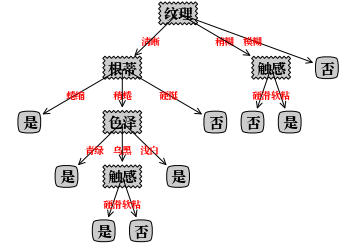

In [11]:
create_plot(tree)